## Q-3. Imagine you have a dataset where you have different categories of data, Now
you need to find the most similar data to the given data by using any 4 different
similarity algorithms. Now you have to build a model which can find the most similar
data to the given data.
Dataset This is the Dataset You can use this dataset for this question.

In [2]:
!pip install kaggle
from google.colab import files
files.upload() # upload the kaggle.json file (api token)

#Make a directory named kaggle and copy the kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json
# !your dataset api command
!kaggle datasets download -d rmisra/news-category-dataset

from zipfile import ZipFile
file_name = 'news-category-dataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (1).json
news-category-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Done


In [32]:
import numpy as np
import pandas as pd

import os
import math
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

# Below libraries are for text processing using NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Below libraries are for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances

In [4]:
df= pd.read_json('/content/News_Category_Dataset_v3.json', lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [5]:
df.shape

(209527, 6)

In [6]:
df.columns

Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [7]:
df.describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max
date,209527,2015-04-30 00:44:14.344308736,2012-01-28,2013-08-10,2015-03-16,2016-11-01,2022-09-23


In [38]:
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

In [37]:
print("Total number of articles : ", df.shape[0])
print("Total number of authors : ", df["authors"].nunique())
print("Total number of unqiue categories : ", df["category"].nunique())

Total number of articles :  209527
Total number of authors :  29169
Total number of unqiue categories :  42


In [9]:
df['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [ ]:
 # ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
#   !pip install -U pandas-profiling
#from pandas_profiling import ProfileReport


In [ ]:
#!pip install --upgrade pip

#!pip install --upgrade Pillow

In [ ]:
#profile = pandas_profiling.ProfileReport(df)
#print(profile)
#profile = ProfileReport(df, minimal=True)
#profile

#df.profile_report()

In [12]:
# drop columns like authors, links and date as they are irrelevent to our problem.
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


In [17]:
# create final dataframe of combined headline and short_description
final_df = new_df.copy()
final_df['length_of_news'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

,category,length_of_news,len_news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,230
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",248
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,133
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,215
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,233


In [18]:
# maximum length of news in each category
lenmax_df = final_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

,category,len_news
24,POLITICS,1486
41,WORLDPOST,1424
4,COLLEGE,1225
16,HEALTHY LIVING,1073
38,WELLNESS,1036


In [19]:
# minimum lenght of news in each category
lenmin_df = final_df.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df.head()

,category,len_news
35,U.S. NEWS,73
8,DIVORCE,66
33,THE WORLDPOST,56
36,WEDDINGS,54
21,MONEY,51


In [29]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 
stopwords.add('will')
import re

(-0.5, 1599.5, 599.5, -0.5)

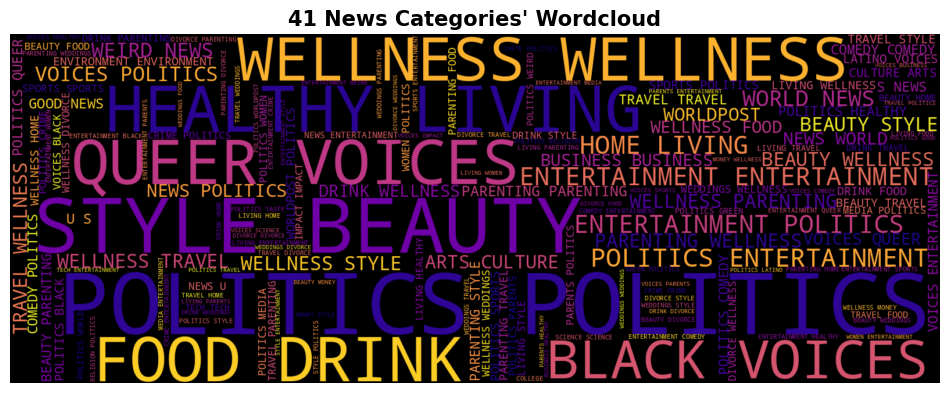

In [30]:
# wordcloud of categories of news articles in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(final_df.category))

plt.title("41 News Categories' Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

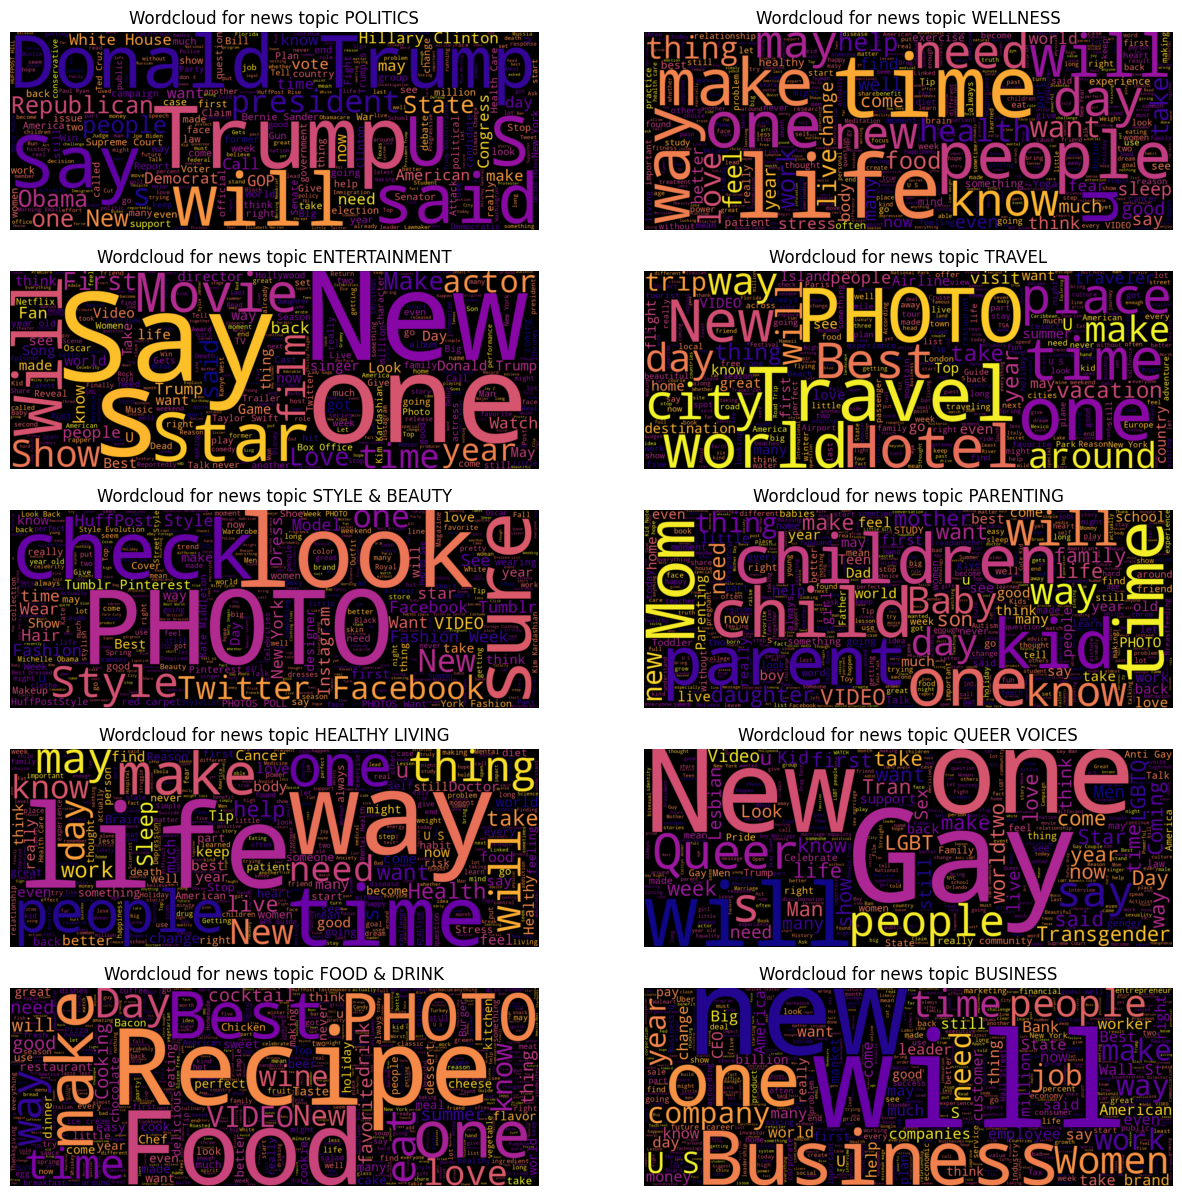

In [31]:
# create new dataframe of category and length of each news articles in that categories
ndf = final_df.copy()
ndf.drop('len_news', inplace=True, axis=1)

# list of top 10  categories in out dataset
categories = cat_df['news_classes'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = ndf[ndf['category'] == i]
    cat_array = cat_ndf['length_of_news'].values  # array of news articles text in each category
    articles_list.append(cat_array)
    
# create a wordcloud instance
wc1 = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

In [34]:
df.sort_values('headline',inplace=True, ascending=False)
duplicated_articles_series = df.duplicated('headline', keep = False)
news_articles = df[~duplicated_articles_series]
print("Total number of articles after removing duplicates:", news_articles.shape[0])

Total number of articles after removing duplicates: 207276


In [39]:
fig = go.Figure([go.Bar(x=df["category"].value_counts().index, y=news_articles["category"].value_counts().values)])
fig['layout'].update(title={"text" : 'Distribution of articles category-wise','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'}, xaxis_title="Category name",yaxis_title="Number of articles")
fig.update_layout(width=800,height=700)
fig

In [40]:
news_articles_per_month = df.resample('m',on = 'date')['headline'].count()
news_articles_per_month

date
2012-01-31     331
2012-02-29    2693
2012-03-31    2880
2012-04-30    2769
2012-05-31    2899
              ... 
2022-05-31     172
2022-06-30     146
2022-07-31     142
2022-08-31     173
2022-09-30     127
Freq: M, Name: headline, Length: 129, dtype: int64

In [42]:
fig = ff.create_distplot([df['headline'].str.len()], ["ht"],show_hist=False,show_rug=False)
fig['layout'].update(title={'text':'PDF','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of a headline",yaxis_title="probability")
fig.update_layout(showlegend = False,width=500,height=500)
fig

In [54]:
df.index = range(df.shape[0])

In [55]:
# Adding a new column containing both day of the week and month, it will be required later while recommending based on day of the week and month
df["day and month"] = df["date"].dt.strftime("%a") + "_" + news_articles["date"].dt.strftime("%b")

In [56]:
news_articles_temp = news_articles.copy()

In [51]:
#news_articles_temp.drop(news_articles_temp.index[5225], axis=0, inplace=True)

In [57]:
stop_words = set(stopwords.words('english'))

In [65]:

for i in range(len(news_articles_temp["headline"])):
    string = ""
    try:
      for word in news_articles_temp["headline"][i].split():
          word = ("".join(e for e in word if e.isalnum()))
          word = word.lower()
          if not word in stop_words:
            string += word + " "  
      if(i%10000==0):
        print(i)           # To track number of records processed
      news_articles_temp.at[i,"headline"] = string.strip()
    except:
      continue

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


In [66]:
lemmatizer = WordNetLemmatizer()

In [92]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [94]:
for i in range(len(news_articles_temp["headline"])):
    string = ""
    try:
      for w in word_tokenize(news_articles_temp["headline"][i]):
          string += lemmatizer.lemmatize(w,pos = "v") + " "
      news_articles_temp.at[i, "headline"] = string.strip()
      if(i%10000==0):
          print(i) 
    except:
      continue


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


In [95]:
headline_vectorizer = CountVectorizer()
headline_features   = headline_vectorizer.fit_transform(news_articles_temp['headline'])

In [96]:
headline_features.get_shape()

(207276, 61483)

In [97]:
pd.set_option('display.max_colwidth', None)  # To display a very long headline completely

In [98]:
def bag_of_words_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(headline_features,headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
               'headline':news_articles['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,1]
    return df.iloc[1:,]

bag_of_words_based_model(134, 11) # Change the row index for any other queried article


============================== Queried article details ==============================
headline :  6 Signs You’re Grinding Your Teeth At Night (And What To Do About It)

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article
1,2015-06-17,How to Cruise Around Cuba Without Breaking the Bank,2.645751
2,2014-09-28,PRAISE TREE-SUS! Man Sees Jesus In Tree Trunk (PHOTO),2.645751
3,2021-06-06,'Cruella' Sequel In The Works Even Though '101 Dalmatians' Already Exists,2.828427
4,2017-03-17,Viral Post Explains Once And For All What A Good Mom Is,2.828427
5,2017-05-29,Texas Lawmaker Calls ICE On Group Protesting Anti-Immigrant Law,2.828427
6,2013-02-02,"Mindy Kaling Sleeps In Rags, RuPaul Reveals Measurements And More Tweets Of The Week (PHOTOS)",2.828427
7,2013-02-02,The Best Late-Night Bars in Rome,2.828427
8,2013-02-02,Super Bowl Food: Finding Healthy Eats In New Orleans,2.828427
9,2014-06-02,Manufacturing Jobs for Women,2.828427
10,2020-03-29,"Mariah Carey Celebrates Her 50th Birthday, Insists She's 'Eternally 12'",2.828427


In [100]:
tfidf_headline_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_headline_features = tfidf_headline_vectorizer.fit_transform(news_articles_temp['headline'])

In [107]:
def tfidf_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(tfidf_headline_features,tfidf_headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
               'headline':news_articles['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    
    #return df.iloc[1:,1]
    return df.iloc[1:,]
tfidf_based_model(134, 11)

============================== Queried article details ==============================
headline :  6 Signs You’re Grinding Your Teeth At Night (And What To Do About It)

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article
1,2014-06-02,Kate Van Dellen: Why I Opted for an Engagement Without the Ring,1.0
2,2020-03-29,"Mariah Carey Celebrates Her 50th Birthday, Insists She's 'Eternally 12'",1.0
3,2013-01-01,A Different Kind of Parenting Resolution,1.0
4,2014-08-24,Counterterrorism Experts: U.S. Partnership With Assad May Be Necessary To Take Out ISIS,1.0
5,2016-09-18,Pro-Putin Party Seen Winning Even More Power In Russia's Parliament,1.0
6,2018-03-06,Democratic Party Set To Show Its Force In Nation's First 2018 Primary,1.0
7,2014-03-11,Seeking Serenity On A Screen,1.0
8,2013-01-31,The Sweet Monster in the Supersized Cup,1.0
9,2018-04-08,Killer Mike Tried To Call Out Joy Reid. She Shut It Down Fast.,1.0
10,2012-12-19,"Child Support Offender, Robert Sand, Arrested In Los Angeles",1.0
